In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt

import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

shap.initjs()

In [2]:
# import glob
# files = glob.glob('./Data/submissions/pennystocks/*.pickle')
# df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
# df.to_pickle('./Data/pennystocks_submissions.pickle')

In [3]:
# Load sentiment analysis package, Vader
vader = SentimentIntensityAnalyzer()

***

#### Read and select relevant columns for submissions and comments files for /r/wallstreetbets

In [4]:
wsb_submissions = pd.read_pickle('./Data/wallstreetbets_submissions.pickle')
# Identify relevant submissions columns
submissions_cols = ['title', 'author', 'created_utc', 'selftext', 'id', 'subreddit', 'subreddit_subscribers', 'score']
wsb_submissions_clean = wsb_submissions[submissions_cols]

wsb_comments = pd.read_pickle('./Data/wallstreetbets_comments.pickle')
comments_cols = ['created_utc', 'link_id', 'body', 'score', 'subreddit', 'is_submitter']
wsb_comments_clean = wsb_comments[comments_cols]

# create'id' column in wsb_comments_clean to match post id in 'wsb_submissions_clean' and drop 'link_id' column.
wsb_comments_clean['id'] = wsb_comments_clean['link_id'].apply(lambda x: str(x)[-6:])
wsb_comments_clean = wsb_comments_clean.drop(columns='link_id')

# Add a "timestamp" column with YYYY-MM-DD time format:
wsb_submissions_clean["timestamp"] = wsb_submissions_clean.created_utc.apply(lambda x: pd.Timestamp(10 ** 9 * x, tz="US/Eastern"))
wsb_comments_clean["timestamp"] = wsb_comments_clean.created_utc.apply(lambda x: pd.Timestamp(10 ** 9 * x, tz="US/Eastern"))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Plot of number of reddit users subscribed to /r/wallstreetbets over the period 08-15-2019 to 08-15-2020.

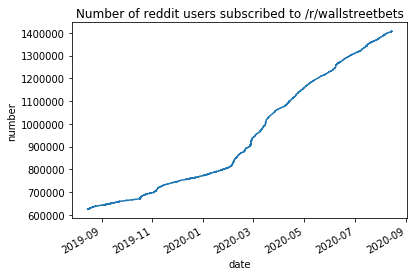

In [5]:
plt.figure()
plt.plot([x.to_pydatetime() for x in wsb_submissions_clean['timestamp']], wsb_submissions_clean['subreddit_subscribers'])
plt.gcf().autofmt_xdate()
plt.title('Number of reddit users subscribed to /r/wallstreetbets')
plt.xlabel('date')
plt.ylabel('number')
plt.show()

#### Sentiment analysis on both submissions and comments

In [6]:
# Applying the sentiment analysis to 'title' column of submissions df
wsb_title_scores = wsb_submissions_clean['title'].astype(str).apply(vader.polarity_scores).tolist()
wsb_title_scores = pd.DataFrame(wsb_title_scores)
wsb_title_scores = wsb_title_scores.add_prefix('title_')

# Merging our headline dataframe with our title sentiment scores dataframe
wsb_submissions_clean = wsb_submissions_clean.join(wsb_title_scores, rsuffix='_right')

In [7]:
# Applying sentiment analysis to 'body' column of submissions df
wsb_body_scores = wsb_submissions_clean['selftext'].astype(str).apply(vader.polarity_scores).tolist()
wsb_body_scores = pd.DataFrame(wsb_body_scores)
wsb_body_scores = wsb_body_scores.add_prefix('body_')

# Merging our headline dataframe with our body sentiment scores dataframe
wsb_submissions_clean = wsb_submissions_clean.join(wsb_body_scores, rsuffix='_right')

In [8]:
# Applying the sentiment analysis to 'body' column of comments df
wsb_comments_scores = wsb_comments_clean['body'].astype(str).apply(vader.polarity_scores).tolist()
wsb_comments_scores = pd.DataFrame(wsb_comments_scores)
wsb_comments_scores = wsb_comments_scores.add_prefix('comments_')

# Merging our headline dataframe with our comments sentiment scores dataframe
wsb_comments_clean = wsb_comments_clean.join(wsb_comments_scores, rsuffix='_right')

***

### Exploring specific companies

#### Tesla

In [9]:
ticker_dict = {
    "TSLA": ["tsla", "tesla", "elon", "musk", "electric vehicle", "model 3", "model x", "model y", "model s"],
    "MSFT": ["msft", "microsoft", "bill gates", "gates", "windows"],
    "BABA": ["ali baba", "ali", "baba", "alibaba", "jack ma"],
    "GOOGL": ["google", "googl", "search engine"],
    "NFLX": ["nflx", "netflix", "streaming"],
    "AMZN": ["amzn", "amazon", "jeff", "bezos"],
    "FB": ["fb", "facebook", "mark", "zuckerberg"],
    "UBER": ["uber", "ride sharing", "lyft"],
    "NVDA": ["nvda", "nvidia"],
    "AMD": ["amd", "lisa", "su"],
    "SNAP": ["snap", "snapchat"],
}

In [10]:
# more tickers (30 most popular)

#AMZN, APHA, BABA, CPRX, DIS, DKNG, ET, FB, GE, 
#    GM, GOOGL,JNJ, JPM, KO, MRNA, MSFT, NKE, NRZ, NTDOY, 
#    NVDA, PENN, PLUG, PTON, PYPL, SNE, TXMD,UBER, V, WMT, ZNGA

In [11]:
tesla_df = wsb_submissions_clean[wsb_submissions_clean['title'].str.contains('|'.join(ticker_dict["TSLA"]))]

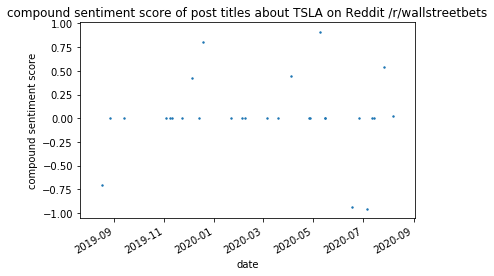

In [12]:
plt.figure()
plt.scatter([x.to_pydatetime() for x in tesla_df['timestamp']], tesla_df['body_compound'], s=2)
plt.gcf().autofmt_xdate()
plt.xlabel('date')
plt.ylabel('compound sentiment score')
plt.title('compound sentiment score of post titles about TSLA on Reddit /r/wallstreetbets')
plt.show()

In [13]:
def filter_by_keyword(df, keywords):
    return df[
        df.title.str.lower().str.contains("|".join(keywords))
        | df.selftext.str.lower().str.contains("|".join(keywords))
    ]

In [14]:
def get_popularity(stock_ticker, fdir="data/robintrack-popularity-history/tmp/popularity_export"):
    popularity = pd.read_csv(f"{fdir}/{stock_ticker}.csv", index_col=0)
    popularity.index = popularity.index.map(pd.Timestamp)
    popularity["date"] = popularity.index.map(lambda x: x.date())
    popularity = popularity.drop_duplicates(subset=["date"], keep="last")
    popularity["log_change"] = np.log(popularity.users_holding).diff()
    return popularity

In [23]:
def make_X_Y(popularity, submissions, comments):
    Y = popularity.log_change
    X = pd.DataFrame(index=popularity.date)

    submissions["date"] = submissions.timestamp.apply(lambda x: x.date())
    comments["date"] = comments.timestamp.apply(lambda x: x.date())

    X["num_posts"] = submissions.groupby("date").title.count()
    X.loc[X.num_posts.isna(), "num_posts"] = 0
    
    X["num_comments"] = comments.groupby("date").body.count()
    X.loc[X.num_comments.isna(), "num_comments"] = 0

    X["mean_post_title_sentiment"] = submissions.groupby("date").title_compound.mean()
    X.loc[X.mean_post_title_sentiment.isna(), "mean_post_title_sentiment"] = 0
    
    X["mean_post_body_sentiment"] = submissions.groupby("date").body_compound.mean()
    X.loc[X.mean_post_body_sentiment.isna(), "mean_post_body_sentiment"] = 0
    
    X["mean_comments_sentiment"] = comments.groupby(["date"]).comments_compound.mean()
    X.loc[X.mean_comments_sentiment.isna(), "mean_comments_sentiment"] = 0

    X["num_up_votes"] = submissions.groupby("date").score.sum()
    X.loc[X.num_up_votes.isna(), "num_up_votes"] = 0

    X["vote_weighted_post_title_sentiment"] = submissions.groupby("date").apply(lambda x: np.sum(x.score * x.title_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_post_title_sentiment.isna(), "vote_weighted_post_title_sentiment"] = 0
    
    X["vote_weighted_post_body_sentiment"] = submissions.groupby(["date"]).apply(lambda x: np.sum(x.score * x.body_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_post_body_sentiment.isna(), "vote_weighted_post_body_sentiment"] = 0
    
    X["vote_weighted_comments_sentiment"] = comments.groupby(["date"]).apply(lambda x: np.sum(x.score * x.comments_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_comments_sentiment.isna(), "vote_weighted_comments_sentiment"] = 0
    
    return X, Y

In [24]:
X = []
Y = []
for ticker, keywords in ticker_dict.items():
    pop = get_popularity(ticker)
    sub = filter_by_keyword(wsb_submissions_clean, keywords)
    com = wsb_comments_clean[wsb_comments_clean.id.isin(sub.id)]
    X_some, Y_some = make_X_Y(pop, sub, com)
    X.append(X_some)
    Y.append(Y_some)
X = pd.concat(X, axis=0).astype(float)
Y = pd.concat(Y, axis=0).astype(float)
mask = np.any(X.isna(), axis=1).values
mask |= Y.isna().values
X = X.loc[~mask]
Y = Y.loc[~mask]
X.shape, Y.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in double_scalars


((8622, 9), (8622,))

In [25]:
Xt, Xv, yt, yv = train_test_split(X, Y, test_size=0.2)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [41]:
params = {
    "eta": .3,
    "max_depth": 10,
    "objective": "reg:squarederror",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 3, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:0.010858	valid-logloss:0.01069
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[2]	train-logloss:0.008615	valid-logloss:0.01103


In [42]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [43]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

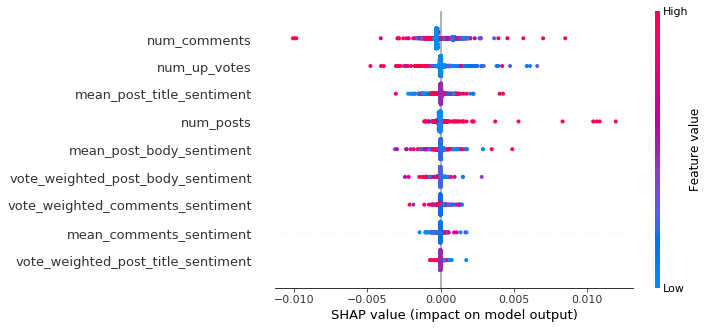

In [44]:
shap.summary_plot(shap_values, Xv)

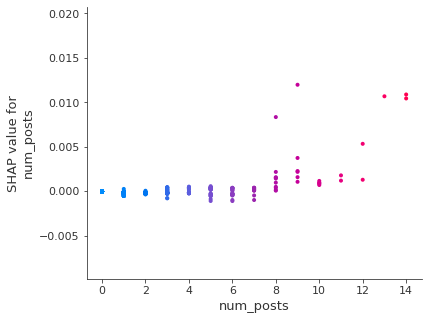

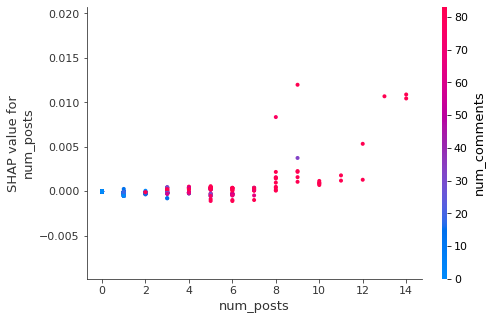

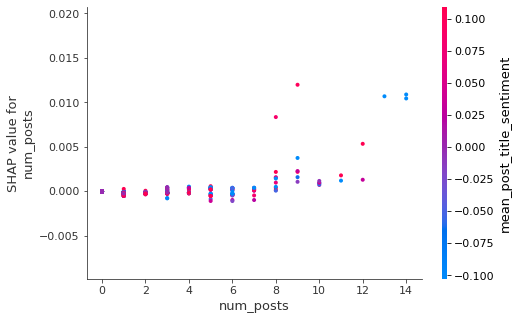

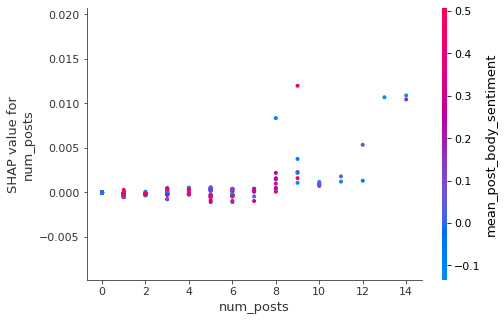

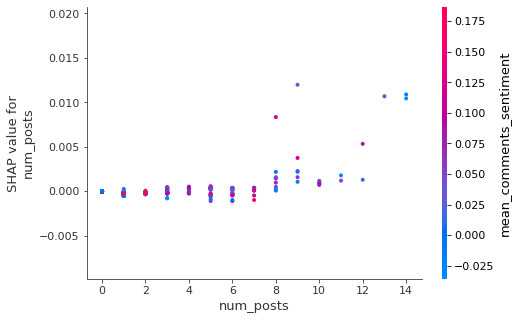

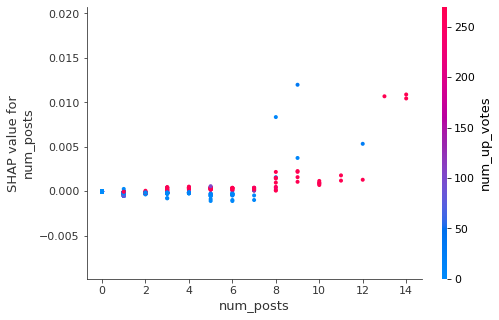

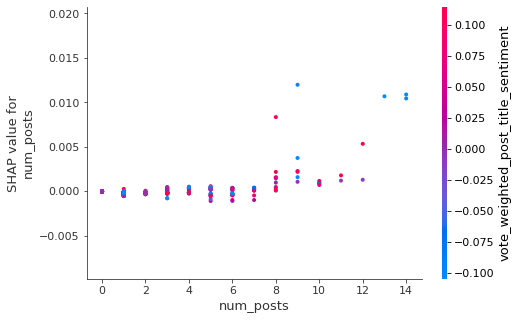

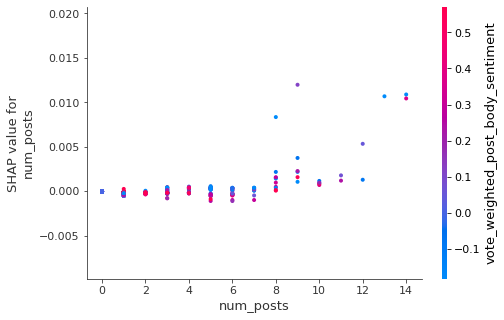

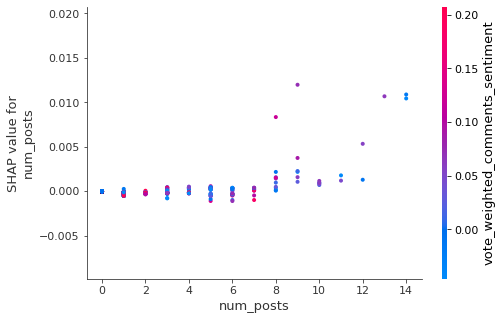

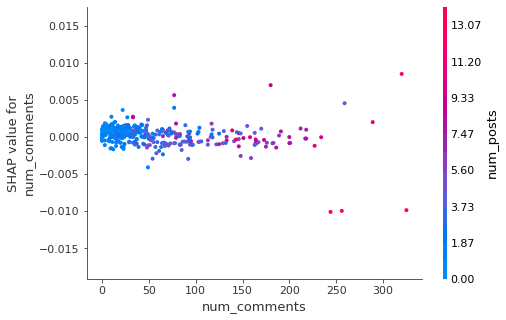

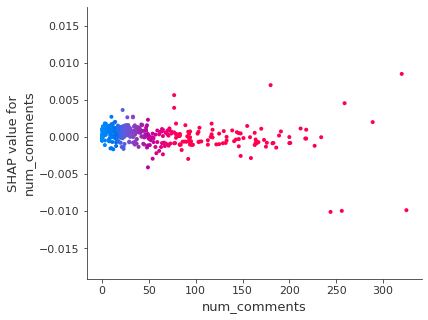

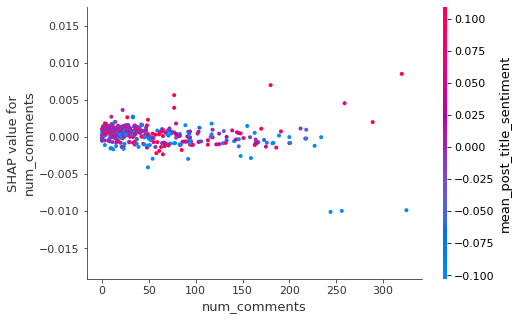

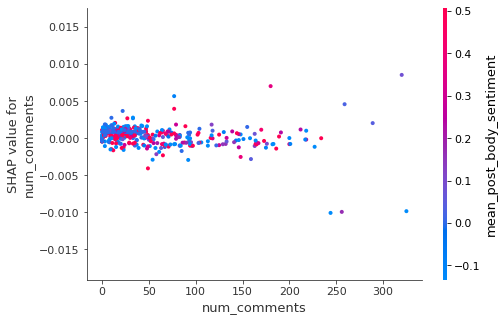

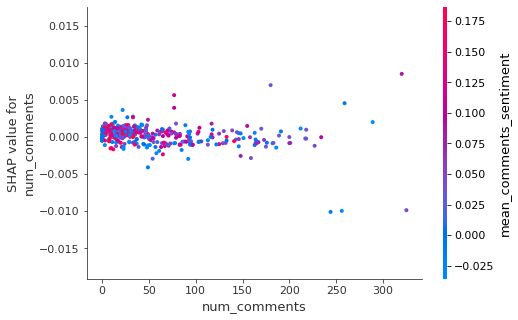

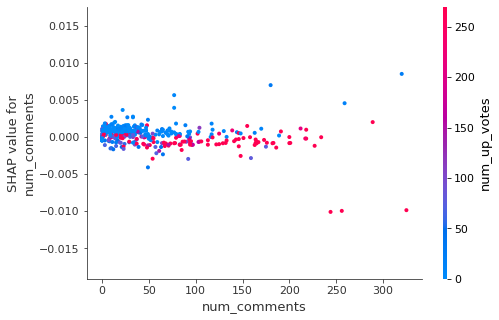

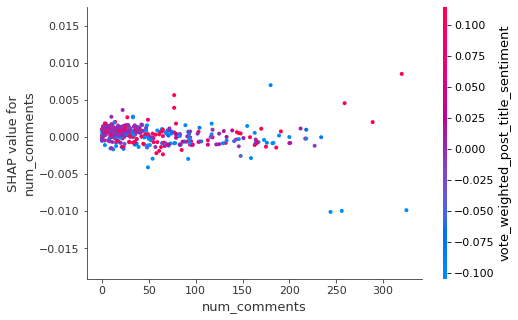

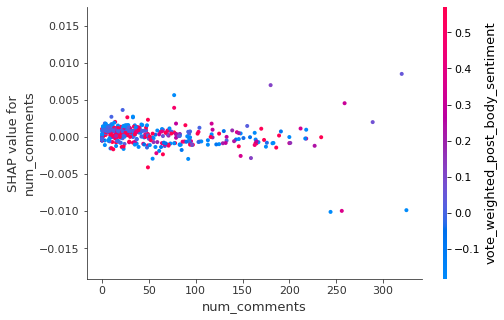

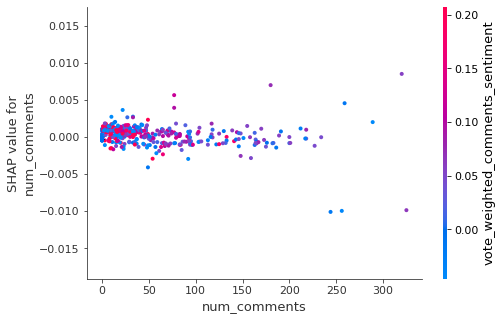

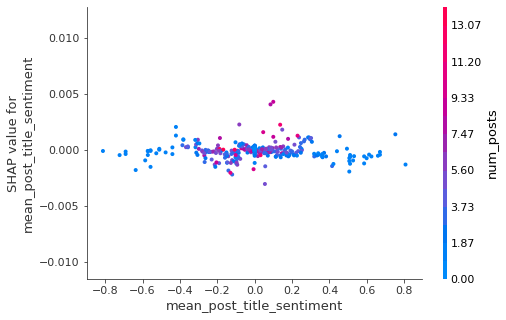

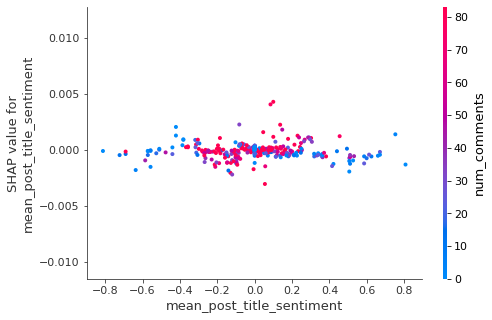

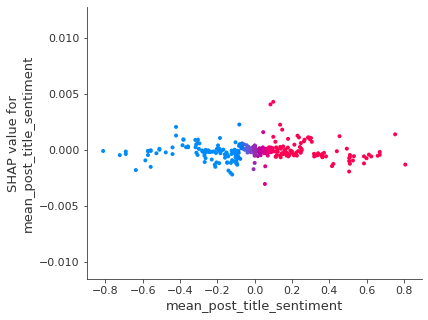

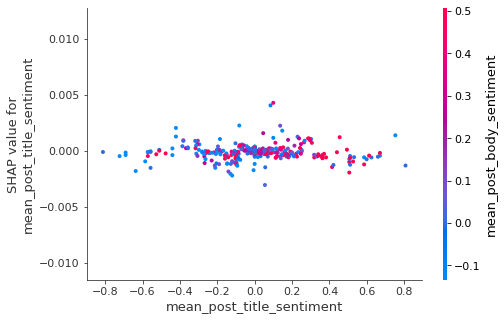

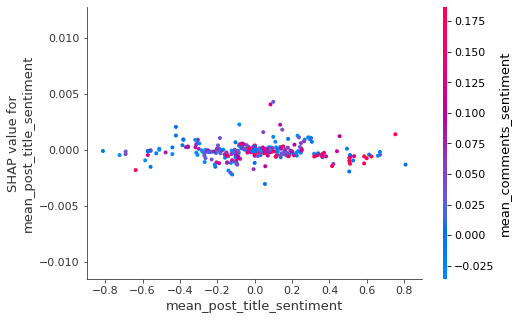

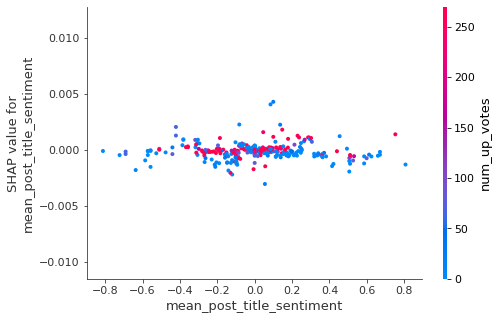

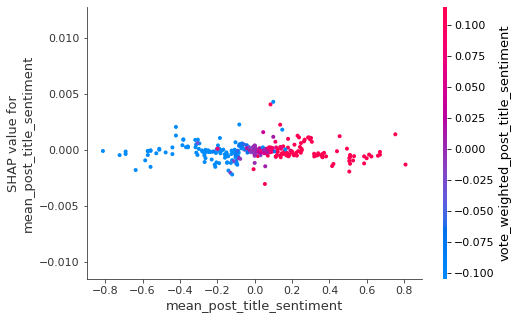

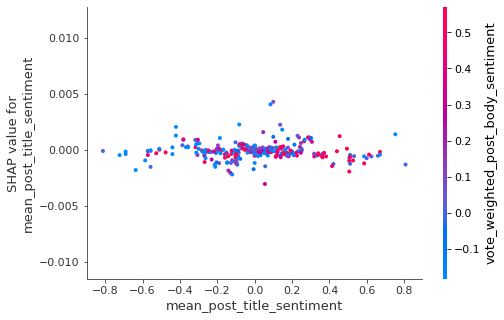

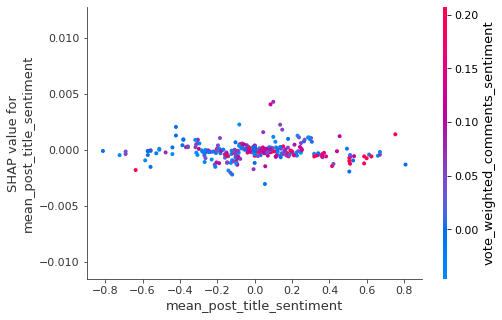

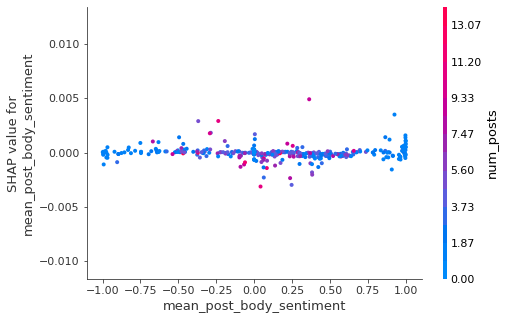

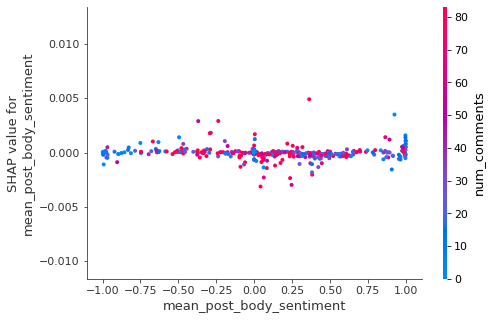

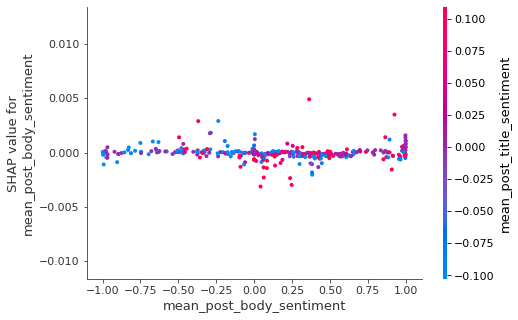

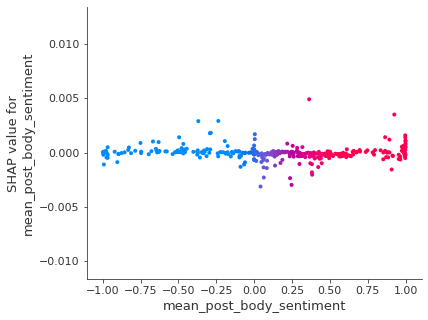

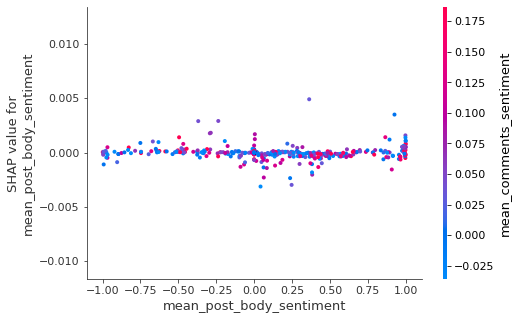

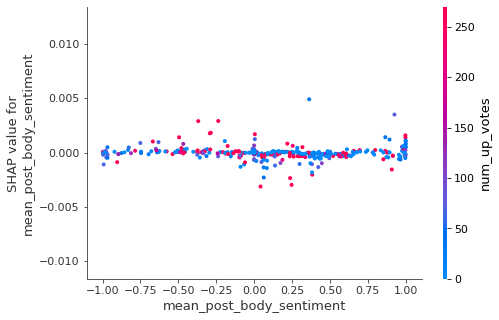

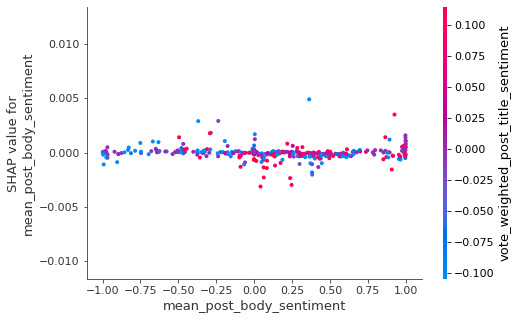

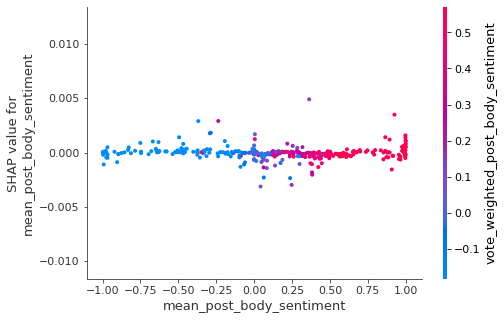

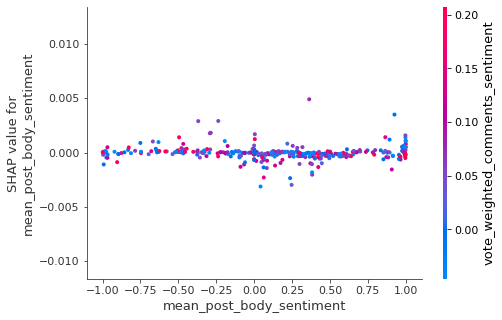

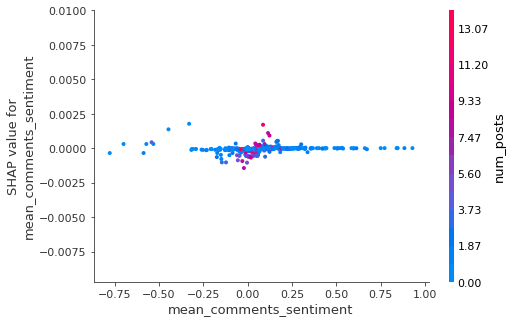

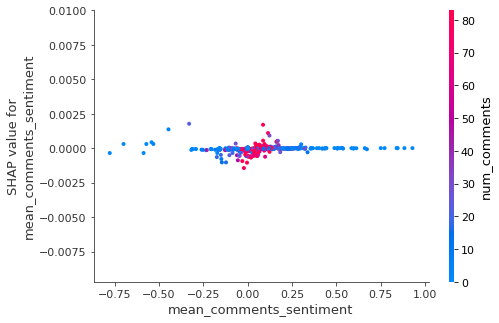

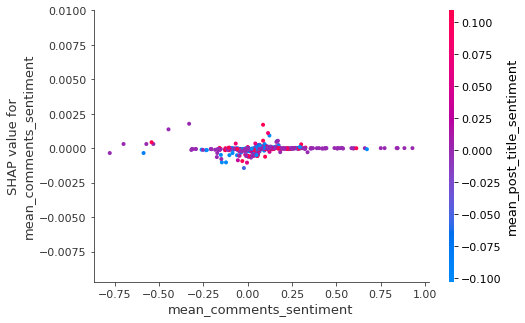

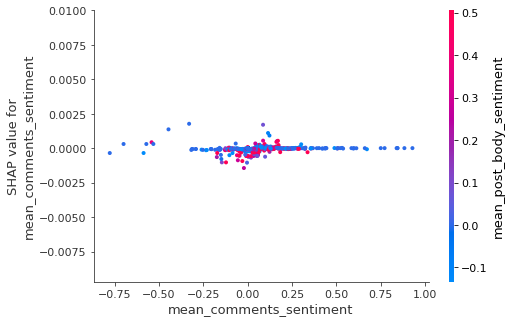

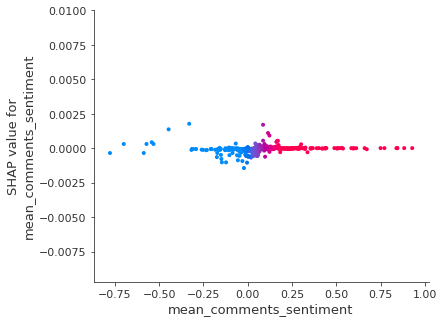

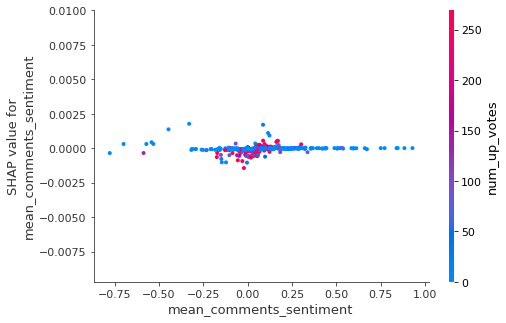

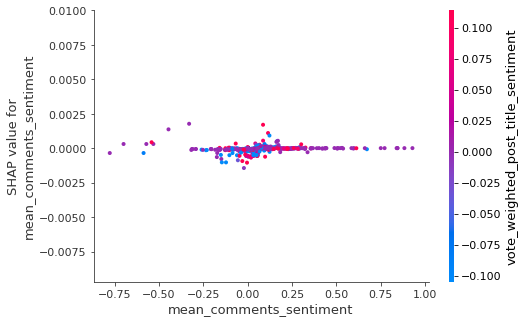

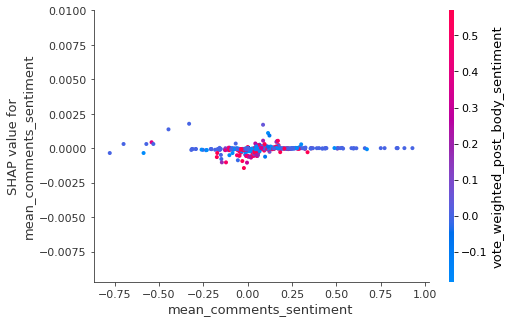

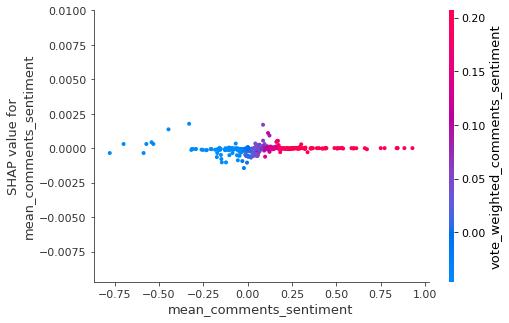

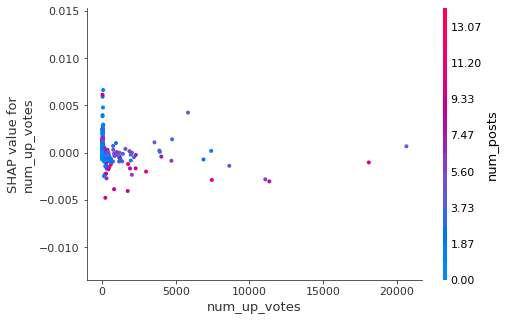

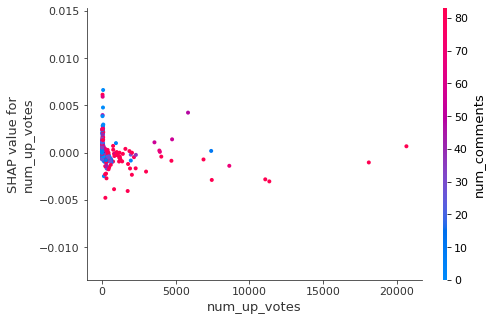

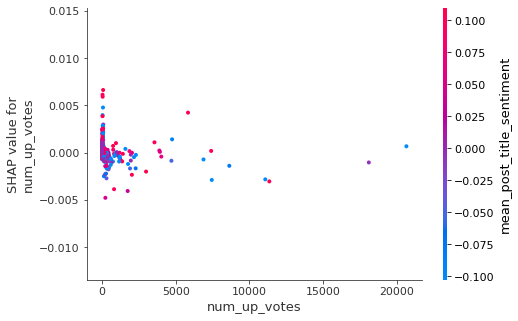

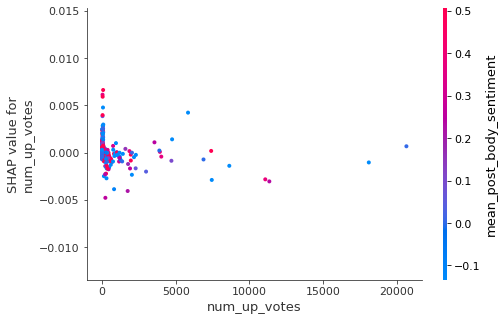

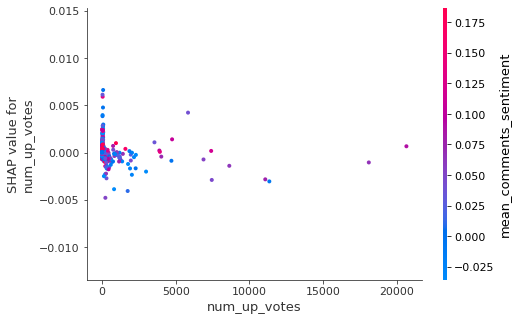

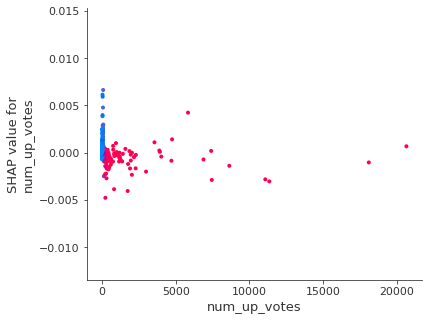

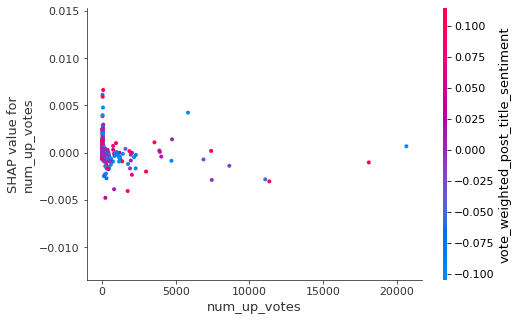

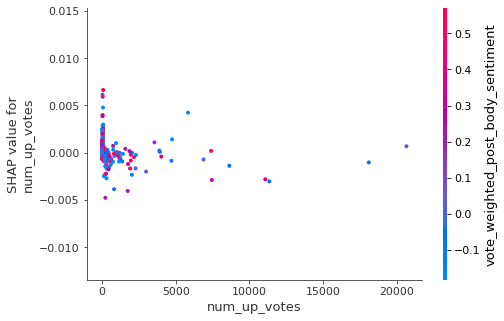

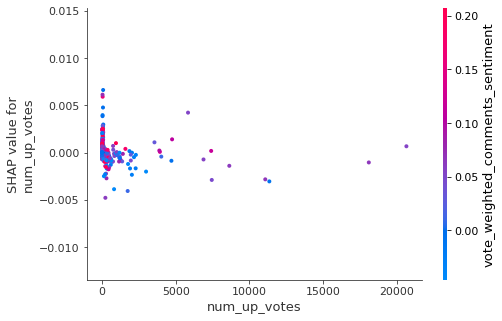

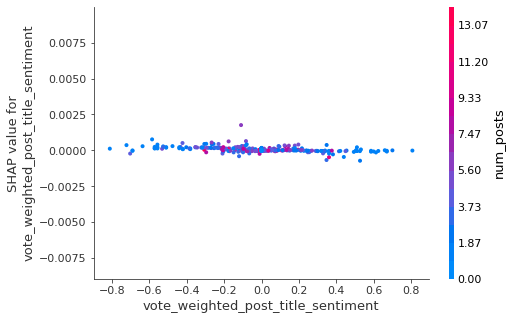

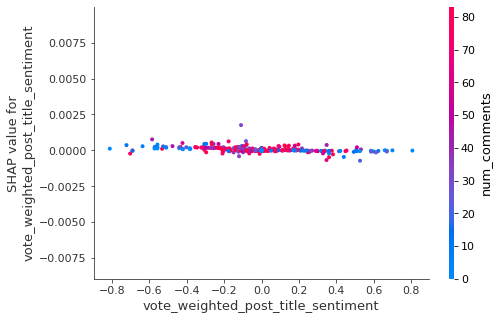

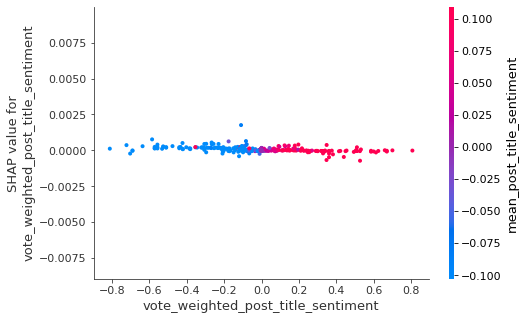

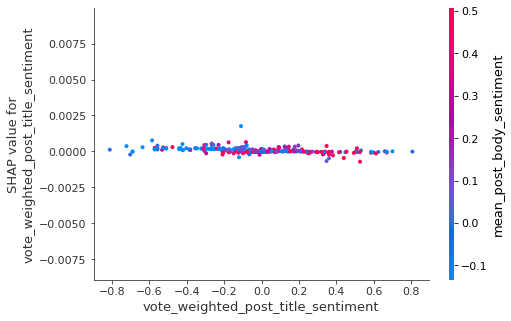

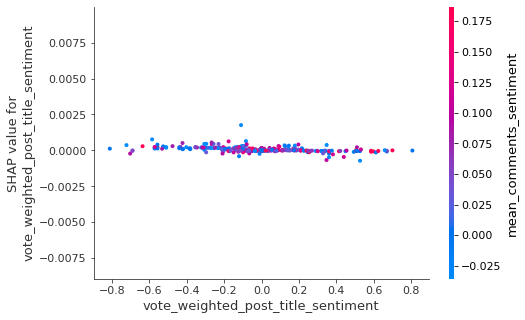

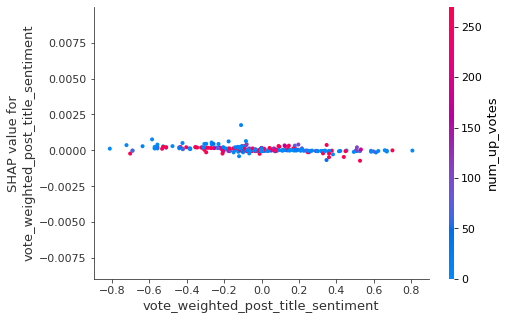

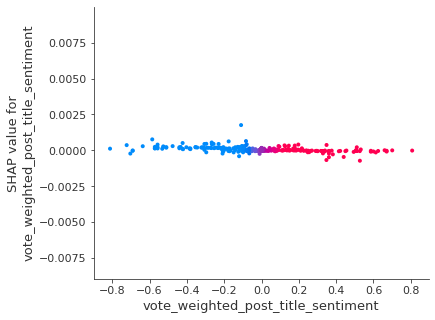

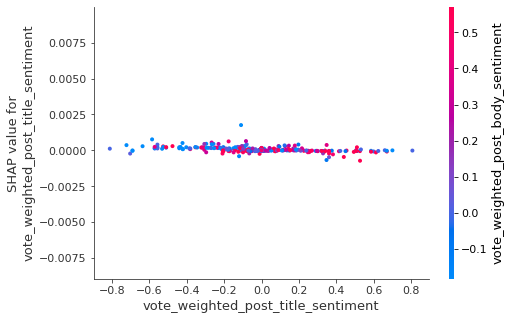

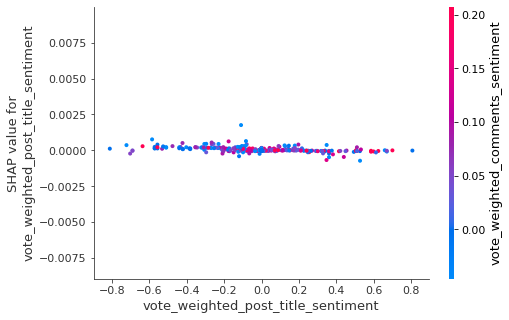

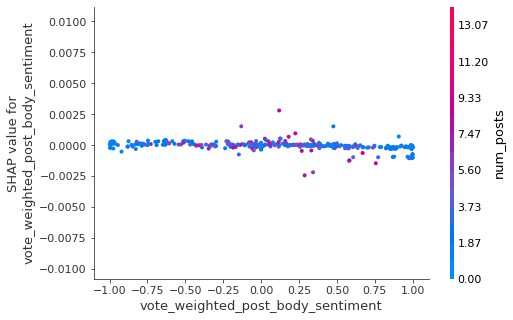

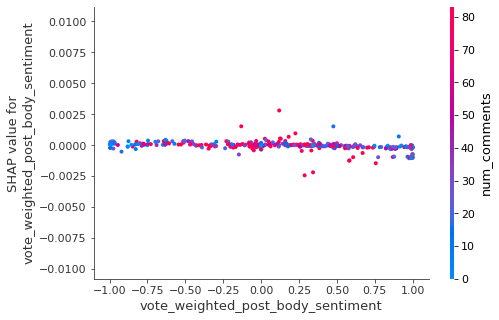

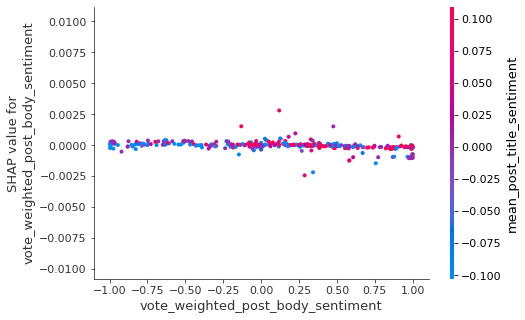

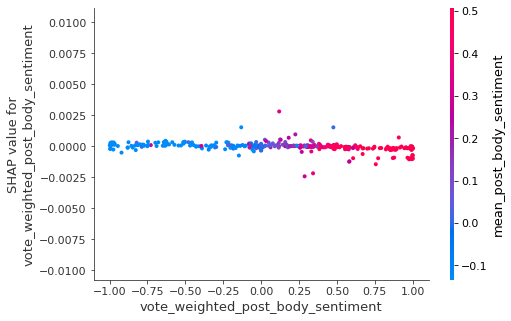

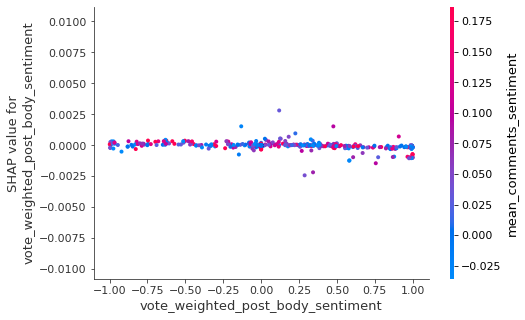

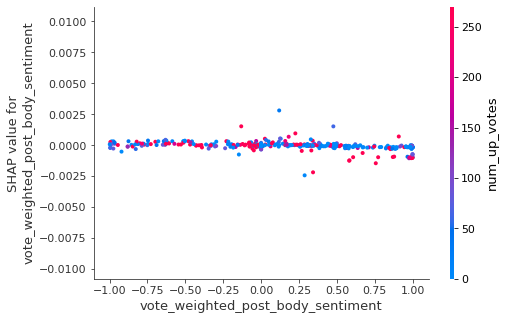

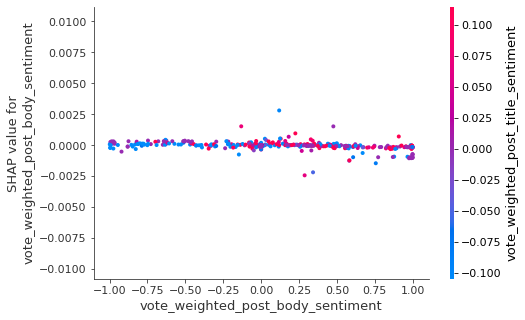

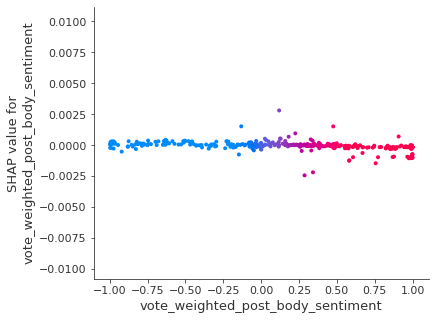

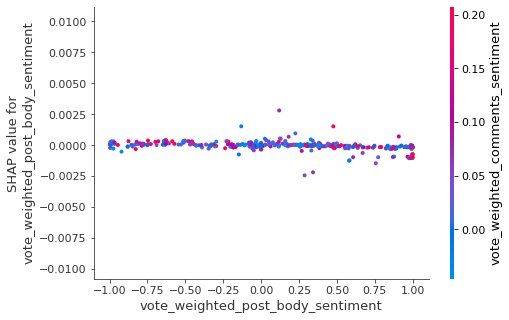

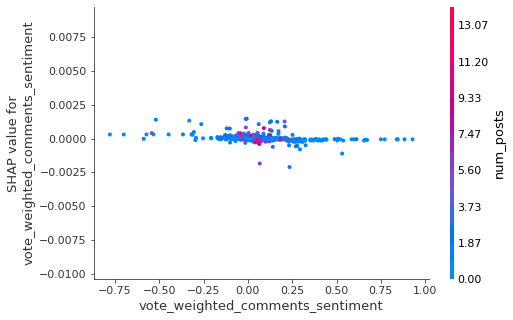

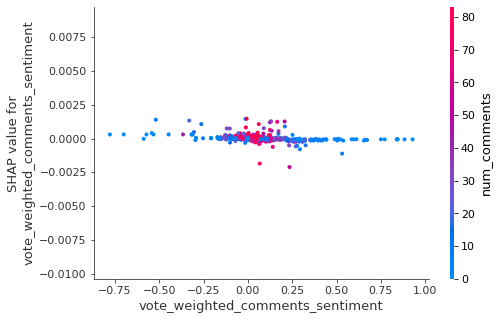

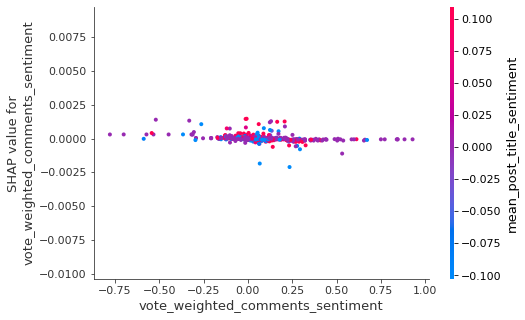

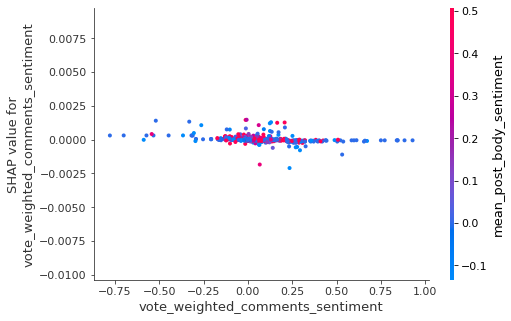

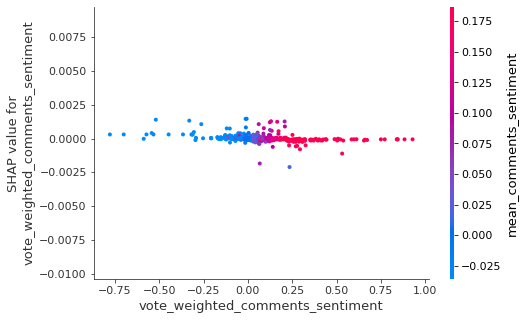

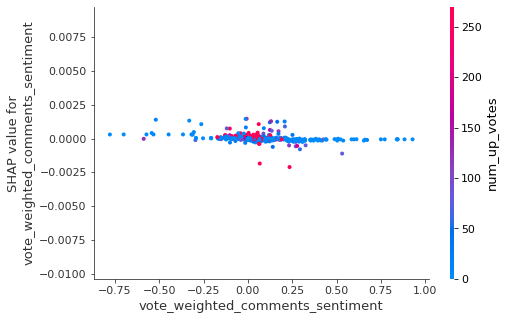

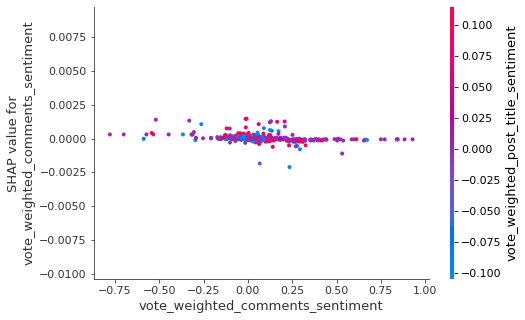

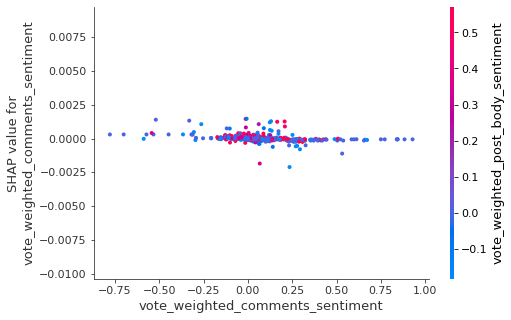

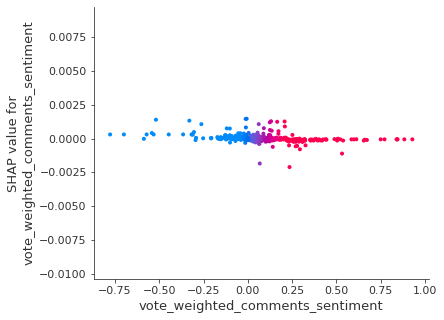

In [48]:
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(x, shap_values, Xv, interaction_index=y)

#### Load Tesla stock price data

***

#### Plot stock price and stock popularity

#### Measure Pearson correlation

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9